In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dropout, Layer, Dense, BatchNormalization, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [2]:
#Read data from "preprocessing.csv"
data = pd.read_csv("Preprocessed.csv")

data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

In [3]:
# Separate scalers for features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Normalize the feature columns
data[['Open', 'High', 'Low', 'Volume']] = feature_scaler.fit_transform(
    data[['Open', 'High', 'Low', 'Volume']]
)

# Normalize the target column
data['Close'] = target_scaler.fit_transform(data[['Close']])

In [4]:
from joblib import Parallel, delayed

def create_sequences(df, seq_length, forecast_length, n_jobs=-1):
    def process(i):
        seq = df.iloc[i:i + seq_length].copy()
        target = df['Close'].iloc[i + seq_length:i + seq_length + forecast_length].values
        return seq, target

    results = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(process)(i)
        for i in range(len(df) - seq_length - forecast_length)
    )
    return results

# Usage
SEQ_LENGTH = 60
FORECAST_LENGTH = 25
sequences = create_sequences(data, SEQ_LENGTH, FORECAST_LENGTH)

# Split into X and y
X, y = zip(*sequences)

X = np.array([
    seq[['Open', 'High', 'Low', 'Close', 'Volume']].values
    for seq in X
])

y = np.array(y)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=False)

In [6]:
del data, sequences, X, y

In [7]:
# Define the Attention layer
@tf.keras.utils.register_keras_serializable()
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [8]:
@tf.keras.utils.register_keras_serializable()
class MultiHeadSelfAttention(Layer):
    def __init__(self, num_heads=4, head_dim=32, dropout_rate=0.1, use_causal_mask=True, **kwargs):
        """
        Args:
            num_heads: Number of attention heads.
            head_dim: Dimension of each head (proj_dim = num_heads * head_dim).
            dropout_rate: Dropout probability.
            use_causal_mask: If True, applies a look-ahead mask (critical for forecasting).
        """
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.proj_dim = num_heads * head_dim
        self.dropout_rate = dropout_rate
        self.use_causal_mask = use_causal_mask

    def build(self, input_shape):
        feature_dim = input_shape[-1]

        # Linear Projections for Query, Key, Value
        self.Wq = self.add_weight(name="Wq", shape=(feature_dim, self.proj_dim), 
                                  initializer="glorot_uniform")
        self.Wk = self.add_weight(name="Wk", shape=(feature_dim, self.proj_dim), 
                                  initializer="glorot_uniform")
        self.Wv = self.add_weight(name="Wv", shape=(feature_dim, self.proj_dim), 
                                  initializer="glorot_uniform")

        # Output Projection
        self.dense = Dense(feature_dim)
        
        # Dropout Layers
        self.att_dropout = Dropout(self.dropout_rate)
        self.output_dropout = Dropout(self.dropout_rate)

        super(MultiHeadSelfAttention, self).build(input_shape)

    def split_heads(self, x, batch_size):
        # Reshape to (Batch, Seq_Len, Num_Heads, Head_Dim)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        # Transpose to (Batch, Num_Heads, Seq_Len, Head_Dim)
        return tf.transpose(x, perm=(0, 2, 1, 3))

    def call(self, x, training=False):
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]

        # 1. Project and Split Heads
        Q = self.split_heads(tf.matmul(x, self.Wq), batch_size)
        K = self.split_heads(tf.matmul(x, self.Wk), batch_size)
        V = self.split_heads(tf.matmul(x, self.Wv), batch_size)

        # 2. Scaled Dot-Product Attention
        # Shape: (Batch, Heads, Seq_Len, Seq_Len)
        score = tf.matmul(Q, K, transpose_b=True)
        
        # Scale scores to stabilize gradients
        scale = tf.math.sqrt(tf.cast(self.head_dim, tf.float32))
        score = score / scale

        # 3. Apply Causal Mask (Look-ahead Mask)
        if self.use_causal_mask:
            # Create a lower triangular matrix of ones (1s in past/present, 0s in future)
            ones = tf.ones((seq_len, seq_len))
            mask = tf.linalg.band_part(ones, -1, 0) # Keep lower triangle
            
            # Invert: 0s in past, 1s in future
            mask = 1.0 - mask
            
            # Add huge negative number to future positions so Softmax makes them 0
            # Shape broadcasting: (1, 1, Seq, Seq)
            mask = mask[tf.newaxis, tf.newaxis, :, :]
            score += (mask * -1e9)

        # 4. Softmax & Dropout
        weights = tf.nn.softmax(score, axis=-1)
        if training:
            weights = self.att_dropout(weights, training=training)

        # 5. Weighted Sum of Values
        attention_output = tf.matmul(weights, V)
        
        # 6. Concatenate Heads
        # Transpose back to (Batch, Seq_Len, Num_Heads, Head_Dim)
        attention_output = tf.transpose(attention_output, perm=(0, 2, 1, 3))
        # Flatten to (Batch, Seq_Len, Proj_Dim)
        concat = tf.reshape(attention_output, (batch_size, -1, self.proj_dim))

        # 7. Final Projection
        output = self.dense(concat)
        if training:
            output = self.output_dropout(output, training=training)

        return output[:, -1, :]

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_heads": self.num_heads,
            "head_dim": self.head_dim,
            "dropout_rate": self.dropout_rate,
            "use_causal_mask": self.use_causal_mask
        })
        return config

In [9]:
def cnn_block(x):
    for _ in range(3):
        x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
        x = Dropout(0.3)(x)
    return x

def tcn_block(x, filters=64, kernel_size=3, dilations=[1, 2, 4, 8]):
    for dilation in dilations:
        res = x
        x = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            padding="causal",
            dilation_rate=dilation,
            activation="relu"
        )(x)
        x = Dropout(0.25)(x)

        x = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            padding="causal",
            dilation_rate=dilation,
            activation="relu"
        )(x)

        # Residual connection
        if res.shape[-1] != x.shape[-1]:
            res = Conv1D(filters, kernel_size=1)(res)

        x = x + res
        x = Dropout(0.25)(x)
    return x

In [22]:
def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = cnn_block(inputs)

    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(32, return_sequences=True)(x)
    x = Dropout(0.3)(x)

    attention = Attention()(x)

    outputs = Dense(FORECAST_LENGTH)(attention)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    return model

model = build_lstm_model((SEQ_LENGTH, 5))
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=200,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=0.001
)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Save the trained model
model.save('lstm_model.h5')

# Evaluate the model
mae = model.evaluate(X_val, y_val)[1]
rmse = model.evaluate(X_val, y_val)[2]
print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 60, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 60, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_4 (Attention)         │ (None, 32)             │            92 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │           825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 294,933 (1.13 MB)

 Trainable params: 294,933 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 154s 148ms/step - loss: 0.0044 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0666 - val_loss: 0.0062 - val_mean_absolute_error: 0.0765 - val_root_mean_squared_error: 0.0788 - learning_rate: 0.0010
Epoch 2/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 145s 144ms/step - loss: 5.9795e-04 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0245 - val_loss: 0.0021 - val_mean_absolute_error: 0.0429 - val_root_mean_squared_error: 0.0455 - learning_rate: 0.0010
Epoch 3/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 143s 143ms/step - loss: 4.2056e-04 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0205 - val_loss: 0.0019 - val_mean_absolute_error: 0.0402 - val_root_mean_squared_error: 0.0439 - learning_rate: 0.0010
Epoch 4/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 143s 143ms/step - loss: 3.2561e-04 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0180 - val_loss: 0.0015 - val_mean_absolute_error: 0.0319 - val_root_mean_squared_error: 0.0382 

223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0015 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0382    
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0015 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0382    
Validation MAE: 0.03189878910779953
Validation RMSE: 0.038174595683813095


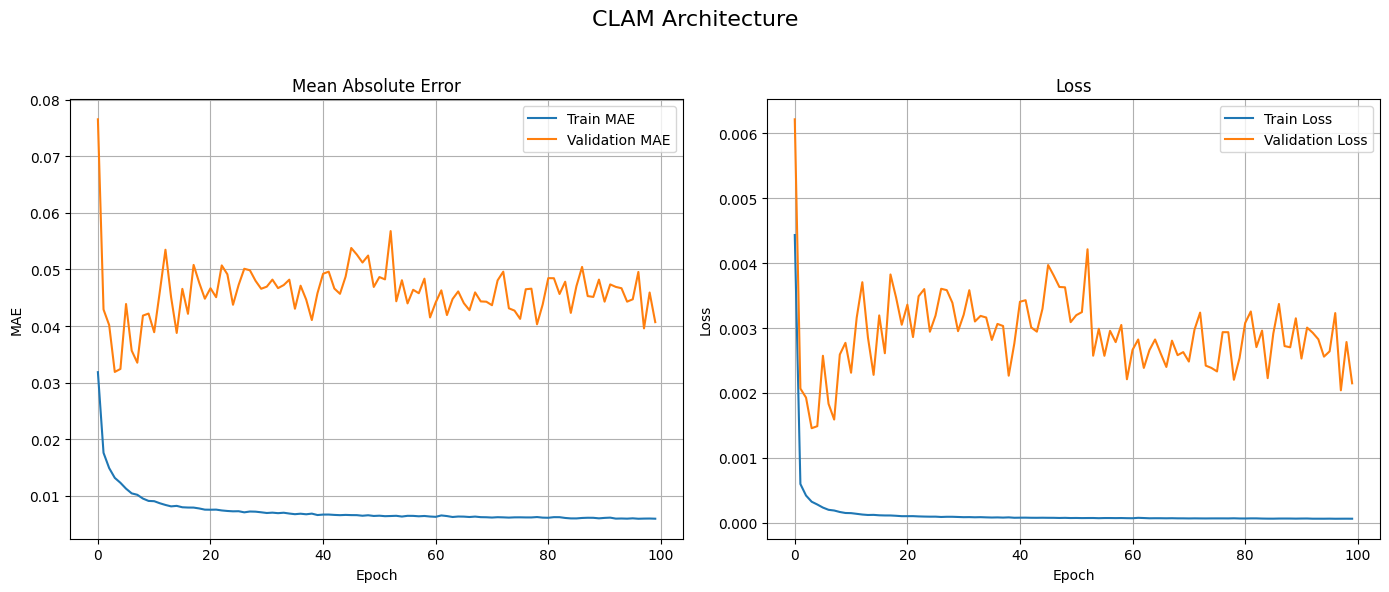

In [23]:
import matplotlib.pyplot as plt

# Create a side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("CLAM Architecture", fontsize=16)

# --- Plot 1: MAE ---
axes[0].plot(history.history['mean_absolute_error'], label='Train MAE')
axes[0].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axes[0].set_title('Mean Absolute Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend(loc='upper right')
axes[0].grid(True)

# --- Plot 2: Loss ---
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.savefig("clam_side_by_side_plots.png", dpi=600)
plt.show()

In [ ]:
# Build the model
def build_bilstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = cnn_block(inputs)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = Dropout(0.3)(x)

    attention = Attention()(x)

    outputs = Dense(FORECAST_LENGTH)(attention)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    return model

model = build_bilstm_model((SEQ_LENGTH, 5))
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=200,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=0.001
)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Save the trained model
model.save('bilstm_model.h5')

# Evaluate the model
mae = model.evaluate(X_val, y_val)[1]
rmse = model.evaluate(X_val, y_val)[2]
print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 60, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 60, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 60, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 60, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_5 (Attention)         │ (None, 64)             │           124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 25)             │         1,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 571,093 (2.18 MB)

 Trainable params: 571,093 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 201s 194ms/step - loss: 0.0024 - mean_absolute_error: 0.0254 - root_mean_squared_error: 0.0489 - val_loss: 0.0374 - val_mean_absolute_error: 0.1911 - val_root_mean_squared_error: 0.1933 - learning_rate: 0.0010
Epoch 2/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 193s 193ms/step - loss: 4.6342e-04 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0215 - val_loss: 0.0216 - val_mean_absolute_error: 0.1464 - val_root_mean_squared_error: 0.1471 - learning_rate: 0.0010
Epoch 3/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 193s 192ms/step - loss: 3.1538e-04 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0178 - val_loss: 0.0126 - val_mean_absolute_error: 0.1103 - val_root_mean_squared_error: 0.1124 - learning_rate: 0.0010
Epoch 4/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 191s 191ms/step - loss: 2.6497e-04 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0163 - val_loss: 0.0082 - val_mean_absolute_error: 0.0826 - val_root_mean_squared_error: 0.0905 

223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0026 - mean_absolute_error: 0.0358 - root_mean_squared_error: 0.0513
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 0.0026 - mean_absolute_error: 0.0358 - root_mean_squared_error: 0.0513
Validation MAE: 0.03580855950713158
Validation RMSE: 0.05132013186812401


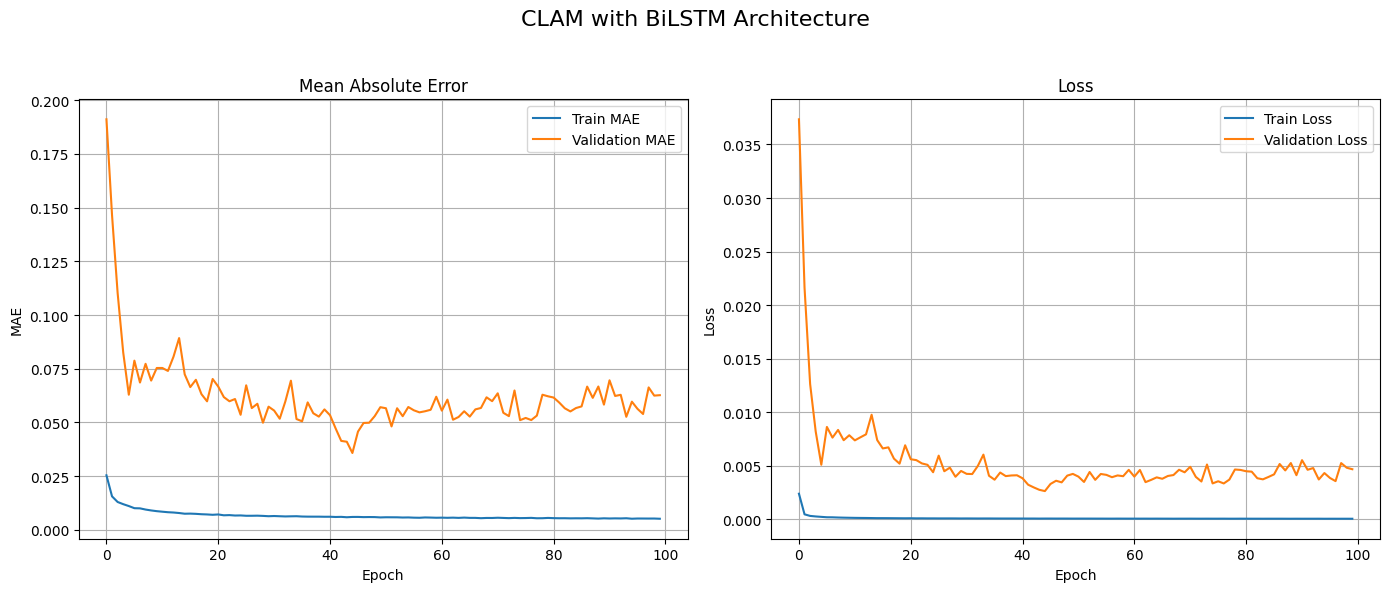

In [25]:
import matplotlib.pyplot as plt

# Create a side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("CLAM with BiLSTM Architecture", fontsize=16)

# --- Plot 1: MAE ---
axes[0].plot(history.history['mean_absolute_error'], label='Train MAE')
axes[0].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axes[0].set_title('Mean Absolute Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend(loc='upper right')
axes[0].grid(True)

# --- Plot 2: Loss ---
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.savefig("clam_bilstm_side_by_side_plots.png", dpi=600)
plt.show()


In [ ]:
from tensorflow.keras.layers import GRU

def create_model(input_shape):
    inputs = Input(shape=input_shape)
    x = cnn_block(inputs)                            

    # Replace LSTM with Bidirectional GRU layers
    x = GRU(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = GRU(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = GRU(32, return_sequences=True)(x)
    x = Dropout(0.3)(x)

    # Attention layer
    attention = Attention()(x)

    outputs = Dense(FORECAST_LENGTH)(attention)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    return model

model = create_model((SEQ_LENGTH, 5))
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=200,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=0.001
)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Save the trained model
model.save('gru_model.h5')

# Evaluate the model
mae = model.evaluate(X_val, y_val)[1]
rmse = model.evaluate(X_val, y_val)[2]
print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 60, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 60, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 60, 32)         │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_2 (Attention)         │ (None, 32)             │            92 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │           825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,253 (965.83 KB)

 Trainable params: 247,253 (965.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 144s 139ms/step - loss: 0.0033 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0571 - val_loss: 0.0585 - val_mean_absolute_error: 0.2381 - val_root_mean_squared_error: 0.2419 - learning_rate: 0.0010
Epoch 2/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - loss: 6.9989e-04 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0265 - val_loss: 0.0458 - val_mean_absolute_error: 0.2094 - val_root_mean_squared_error: 0.2141 - learning_rate: 0.0010
Epoch 3/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 136s 136ms/step - loss: 4.8834e-04 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0221 - val_loss: 0.0453 - val_mean_absolute_error: 0.2085 - val_root_mean_squared_error: 0.2129 - learning_rate: 0.0010
Epoch 4/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 136s 135ms/step - loss: 4.0163e-04 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0200 - val_loss: 0.0404 - val_mean_absolute_error: 0.1969 - val_root_mean_squared_error: 0.2009 

223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0038 - mean_absolute_error: 0.0598 - root_mean_squared_error: 0.0620
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0038 - mean_absolute_error: 0.0598 - root_mean_squared_error: 0.0620
Validation MAE: 0.05983750522136688
Validation RMSE: 0.062039218842983246


In [ ]:
def create_tcn_model(input_shape):
    inputs = Input(shape=input_shape)

    x = cnn_block(inputs)

    # ---- TCN Block (stacked dilated convolutions + residuals) ----
    x = tcn_block(
        x,
        filters=64,
        kernel_size=3,
        dilations=[1, 2, 4, 8, 16]   # very important for TCN!
    )

    # ---- second TCN stage (deeper model) ----
    x = tcn_block(
        x,
        filters=32,
        kernel_size=3,
        dilations=[1, 2, 4, 8]
    )

    # ---- Attention Layer ----
    attention_out = Attention()(x)

    # ---- Output Layer (forecast next N timesteps) ----
    outputs = Dense(FORECAST_LENGTH)(attention_out)

    model = Model(inputs, outputs)

    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.RootMeanSquaredError()
        ]
    )

    return model


# Build model
model = create_tcn_model((SEQ_LENGTH, 5))
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Save
model.save('tcn_model.h5')

# Evaluate
mae = model.evaluate(X_val, y_val)[1]
rmse = model.evaluate(X_val, y_val)[2]
print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 60, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 60, 128)   │      2,048 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 60, 128)   │          0 │ conv1d_35[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 60, 128)   │     49,280 │ dropout_47[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 60, 128)   │          0 │ conv1d_36[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 60, 128)   │     49,280 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 60, 128)   │          0 │ conv1d_37[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 60, 64)    │     24,640 │ dropout_49[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 60, 64)    │          0 │ conv1d_38[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 60, 64)    │     12,352 │ dropout_50[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 60, 64)    │      8,256 │ dropout_49[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 60, 64)    │          0 │ conv1d_39[0][0],  │
│                     │                   │            │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 60, 64)    │          0 │ add_9[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 60, 64)    │     12,352 │ dropout_51[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 60, 64)    │          0 │ conv1d_41[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 60, 64)    │     12,352 │ dropout_52[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 60, 64)    │          0 │ conv1d_42[0][0],  │
│                     │                   │            │ dropout_51[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 60, 64)    │          0 │ add_10[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 60, 64)    │     12,352 │ dropout_53[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 60, 64)    │          0 │ conv1d_43[0][0] 

 Total params: 275,573 (1.05 MB)

 Trainable params: 275,573 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 111s 103ms/step - loss: 0.0093 - mean_absolute_error: 0.0516 - root_mean_squared_error: 0.0967 - val_loss: 0.3784 - val_mean_absolute_error: 0.6086 - val_root_mean_squared_error: 0.6151 - learning_rate: 0.0010
Epoch 2/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 101s 101ms/step - loss: 0.0019 - mean_absolute_error: 0.0320 - root_mean_squared_error: 0.0434 - val_loss: 0.3686 - val_mean_absolute_error: 0.6004 - val_root_mean_squared_error: 0.6071 - learning_rate: 0.0010
Epoch 3/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 102s 101ms/step - loss: 0.0014 - mean_absolute_error: 0.0275 - root_mean_squared_error: 0.0369 - val_loss: 0.2769 - val_mean_absolute_error: 0.5192 - val_root_mean_squared_error: 0.5263 - learning_rate: 0.0010
Epoch 4/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 104s 104ms/step - loss: 0.0011 - mean_absolute_error: 0.0247 - root_mean_squared_error: 0.0328 - val_loss: 0.2295 - val_mean_absolute_error: 0.4752 - val_root_mean_squared_error: 0.4791 - learning_r

223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0179 - mean_absolute_error: 0.1327 - root_mean_squared_error: 0.1338
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0179 - mean_absolute_error: 0.1327 - root_mean_squared_error: 0.1338
Validation MAE: 0.13268226385116577
Validation RMSE: 0.13379953801631927


In [ ]:
def build_lstm_mhsa_model(input_shape):
    inputs = Input(shape=input_shape)
    x = cnn_block(inputs)

    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(32, return_sequences=True)(x)
    x = Dropout(0.3)(x)

    attention = MultiHeadSelfAttention(
        num_heads=4,
        head_dim=32,
        dropout_rate=0.1,
        use_causal_mask=True  # Ensures no future peeking
    )(x)

    outputs = Dense(FORECAST_LENGTH)(attention)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse",
                  metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

    return model

model = build_lstm_mhsa_model((SEQ_LENGTH, 5))
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=200,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=0.001
)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Save the trained model
model.save('lstm_mhsa_model.h5')

# Evaluate the model
mae = model.evaluate(X_val, y_val)[1]
rmse = model.evaluate(X_val, y_val)[2]
print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_58 (Conv1D)              │ (None, 60, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_59 (Conv1D)              │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_60 (Conv1D)              │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 60, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_self_attention_1     │ (None, 32)             │        16,416 │
│ (MultiHeadSelfAttention)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │           825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,257 (1.19 MB)

 Trainable params: 311,257 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 194s 188ms/step - loss: 0.0095 - mean_absolute_error: 0.0574 - root_mean_squared_error: 0.0977 - val_loss: 0.0107 - val_mean_absolute_error: 0.0994 - val_root_mean_squared_error: 0.1033 - learning_rate: 0.0010
Epoch 2/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 184s 184ms/step - loss: 0.0020 - mean_absolute_error: 0.0327 - root_mean_squared_error: 0.0443 - val_loss: 0.0211 - val_mean_absolute_error: 0.1415 - val_root_mean_squared_error: 0.1454 - learning_rate: 0.0010
Epoch 3/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 183s 183ms/step - loss: 0.0012 - mean_absolute_error: 0.0268 - root_mean_squared_error: 0.0352 - val_loss: 0.0069 - val_mean_absolute_error: 0.0798 - val_root_mean_squared_error: 0.0833 - learning_rate: 0.0010
Epoch 4/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 179s 179ms/step - loss: 9.3525e-04 - mean_absolute_error: 0.0235 - root_mean_squared_error: 0.0306 - val_loss: 0.0094 - val_mean_absolute_error: 0.0937 - val_root_mean_squared_error: 0.0969 - learni

223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0014 - mean_absolute_error: 0.0315 - root_mean_squared_error: 0.0369
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0014 - mean_absolute_error: 0.0315 - root_mean_squared_error: 0.0369
Validation MAE: 0.03147703409194946
Validation RMSE: 0.036885492503643036


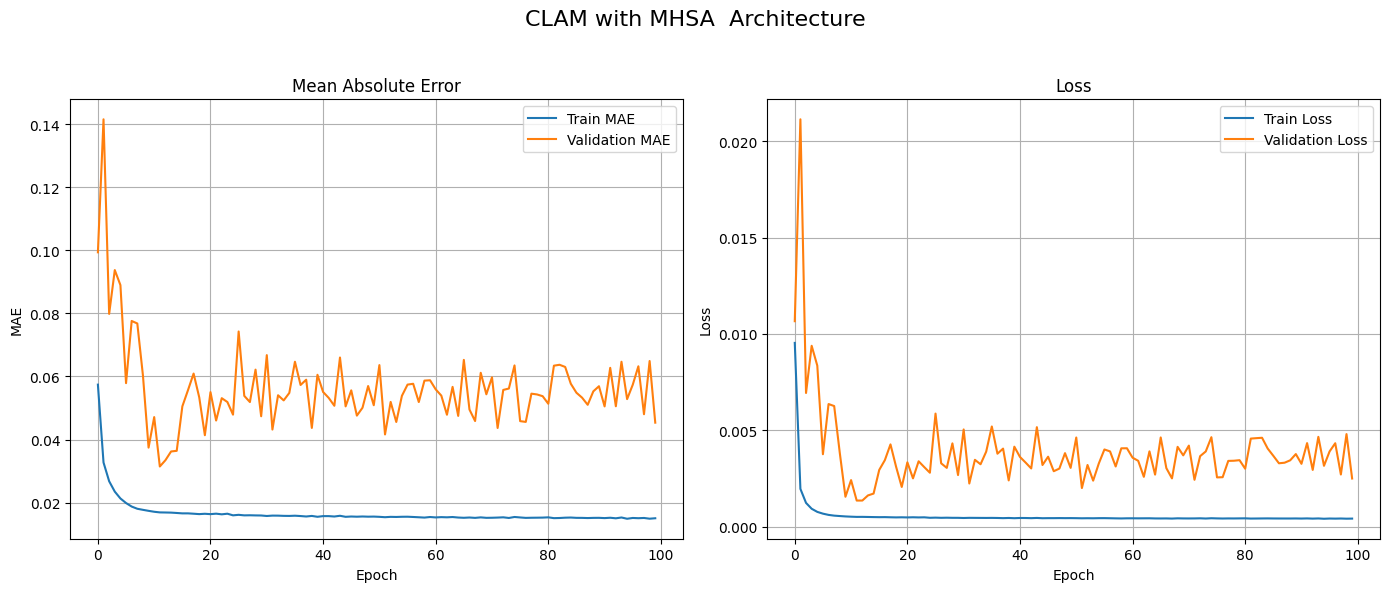

In [ ]:
import matplotlib.pyplot as plt

# Create a side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("CLAM with MHSA  Architecture", fontsize=16)

# --- Plot 1: MAE ---
axes[0].plot(history.history['mean_absolute_error'], label='Train MAE')
axes[0].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axes[0].set_title('Mean Absolute Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend(loc='upper right')
axes[0].grid(True)

# --- Plot 2: Loss ---
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.savefig("clam_mhsaside_by_side_plots.png", dpi=600)
plt.show()


In [ ]:
def build_bilstm_mhsa_model(input_shape):
    inputs = Input(shape=input_shape)
    x = cnn_block(inputs)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = Dropout(0.3)(x)

    attention = MultiHeadSelfAttention(
        num_heads=4,
        head_dim=32,
        dropout_rate=0.1,
        use_causal_mask=True  # Ensures no future peeking
    )(x)

    outputs = Dense(FORECAST_LENGTH)(attention)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse",
                  metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

    return model

model = build_bilstm_mhsa_model((SEQ_LENGTH, 5))
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=200,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=0.001
)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Save the trained model
model.save('bilstm_mhsa_model.h5')

# Evaluate the model
mae = model.evaluate(X_val, y_val)[1]
rmse = model.evaluate(X_val, y_val)[2]
print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")

2025-11-30 11:19:21.244724: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 60, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 60, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_self_attention       │ (None, 64)             │        32,832 │
│ (MultiHeadSelfAttention)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,801 (2.30 MB)

 Trainable params: 603,801 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 249s 240ms/step - loss: 0.0050 - mean_absolute_error: 0.0442 - root_mean_squared_error: 0.0710 - val_loss: 0.0459 - val_mean_absolute_error: 0.2114 - val_root_mean_squared_error: 0.2142 - learning_rate: 0.0010
Epoch 2/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 235s 235ms/step - loss: 0.0013 - mean_absolute_error: 0.0266 - root_mean_squared_error: 0.0359 - val_loss: 0.0535 - val_mean_absolute_error: 0.2288 - val_root_mean_squared_error: 0.2313 - learning_rate: 0.0010
Epoch 3/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 236s 235ms/step - loss: 9.1363e-04 - mean_absolute_error: 0.0231 - root_mean_squared_error: 0.0302 - val_loss: 0.0302 - val_mean_absolute_error: 0.1716 - val_root_mean_squared_error: 0.1738 - learning_rate: 0.0010
Epoch 4/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 233s 233ms/step - loss: 6.7475e-04 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0260 - val_loss: 0.0340 - val_mean_absolute_error: 0.1839 - val_root_mean_squared_error: 0.1845 - le

223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0050 - mean_absolute_error: 0.0611 - root_mean_squared_error: 0.0707
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.0050 - mean_absolute_error: 0.0611 - root_mean_squared_error: 0.0707
Validation MAE: 0.06108804792165756
Validation RMSE: 0.07070983201265335


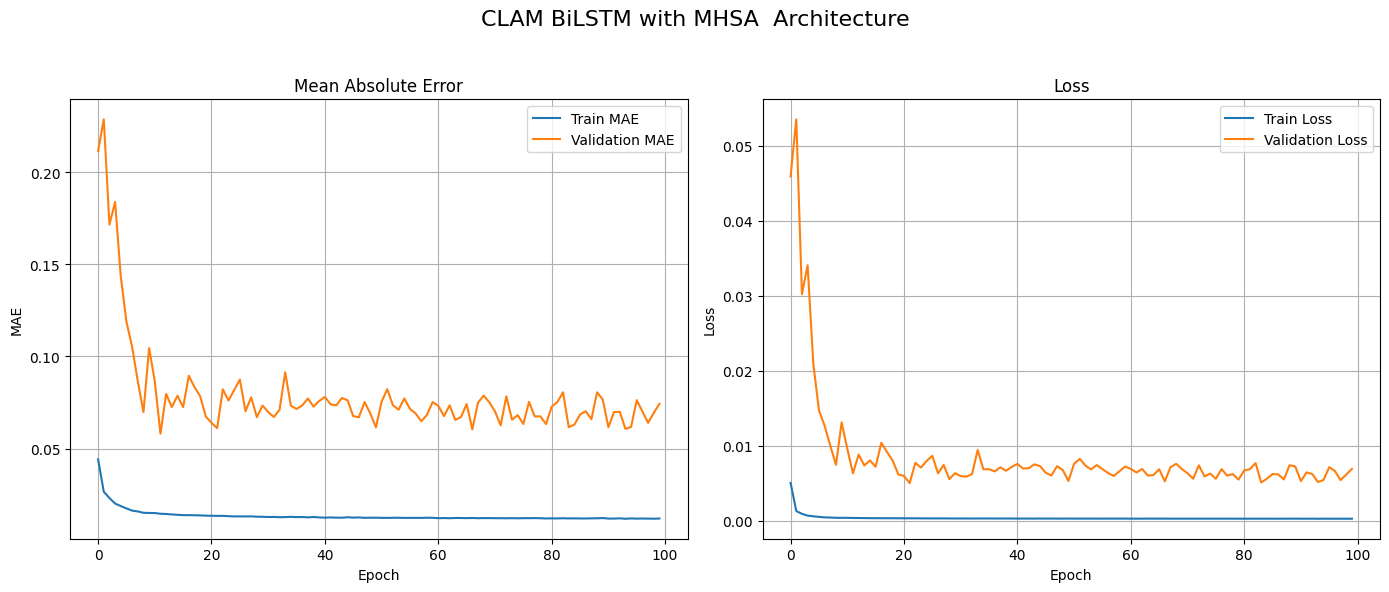

In [12]:
import matplotlib.pyplot as plt

# Create a side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("CLAM BiLSTM with MHSA  Architecture", fontsize=16)

# --- Plot 1: MAE ---
axes[0].plot(history.history['mean_absolute_error'], label='Train MAE')
axes[0].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axes[0].set_title('Mean Absolute Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend(loc='upper right')
axes[0].grid(True)

# --- Plot 2: Loss ---
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.savefig("clam_bilstm_mhsa_side_by_side_plots.png", dpi=600)
plt.show()


In [ ]:
def build_gru_mhsa_model(input_shape):
    inputs = Input(shape=input_shape)
    x = cnn_block(inputs)

    # Replace LSTM with Bidirectional GRU layers
    x = GRU(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = GRU(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = GRU(32, return_sequences=True)(x)
    x = Dropout(0.3)(x)

    attention = MultiHeadSelfAttention(
        num_heads=4,
        head_dim=32,
        dropout_rate=0.1,
        use_causal_mask=True  # Ensures no future peeking
    )(x)

    outputs = Dense(FORECAST_LENGTH)(attention)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse",
                  metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

    return model

model = build_gru_mhsa_model((SEQ_LENGTH, 5))
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=200,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=0.001
)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Save the trained model
model.save('gru_mhsa_model.h5')

# Evaluate the model
mae = model.evaluate(X_val, y_val)[1]
rmse = model.evaluate(X_val, y_val)[2]
print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_67 (Conv1D)              │ (None, 60, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_68 (Conv1D)              │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_69 (Conv1D)              │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 60, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 60, 32)         │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_self_attention_4     │ (None, 32)             │        16,416 │
│ (MultiHeadSelfAttention)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │           825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,577 (1.01 MB)

 Trainable params: 263,577 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 196s 190ms/step - loss: 0.0083 - mean_absolute_error: 0.0558 - root_mean_squared_error: 0.0910 - val_loss: 0.0279 - val_mean_absolute_error: 0.1637 - val_root_mean_squared_error: 0.1669 - learning_rate: 0.0010
Epoch 2/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 189s 188ms/step - loss: 0.0020 - mean_absolute_error: 0.0329 - root_mean_squared_error: 0.0447 - val_loss: 0.0406 - val_mean_absolute_error: 0.1972 - val_root_mean_squared_error: 0.2015 - learning_rate: 0.0010
Epoch 3/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 189s 188ms/step - loss: 0.0013 - mean_absolute_error: 0.0272 - root_mean_squared_error: 0.0356 - val_loss: 0.0314 - val_mean_absolute_error: 0.1733 - val_root_mean_squared_error: 0.1773 - learning_rate: 0.0010
Epoch 4/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 189s 189ms/step - loss: 9.6815e-04 - mean_absolute_error: 0.0240 - root_mean_squared_error: 0.0311 - val_loss: 0.0289 - val_mean_absolute_error: 0.1658 - val_root_mean_squared_error: 0.1701 - learni

223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0056 - mean_absolute_error: 0.0728 - root_mean_squared_error: 0.0746
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0056 - mean_absolute_error: 0.0728 - root_mean_squared_error: 0.0746
Validation MAE: 0.07280754297971725
Validation RMSE: 0.07463680952787399


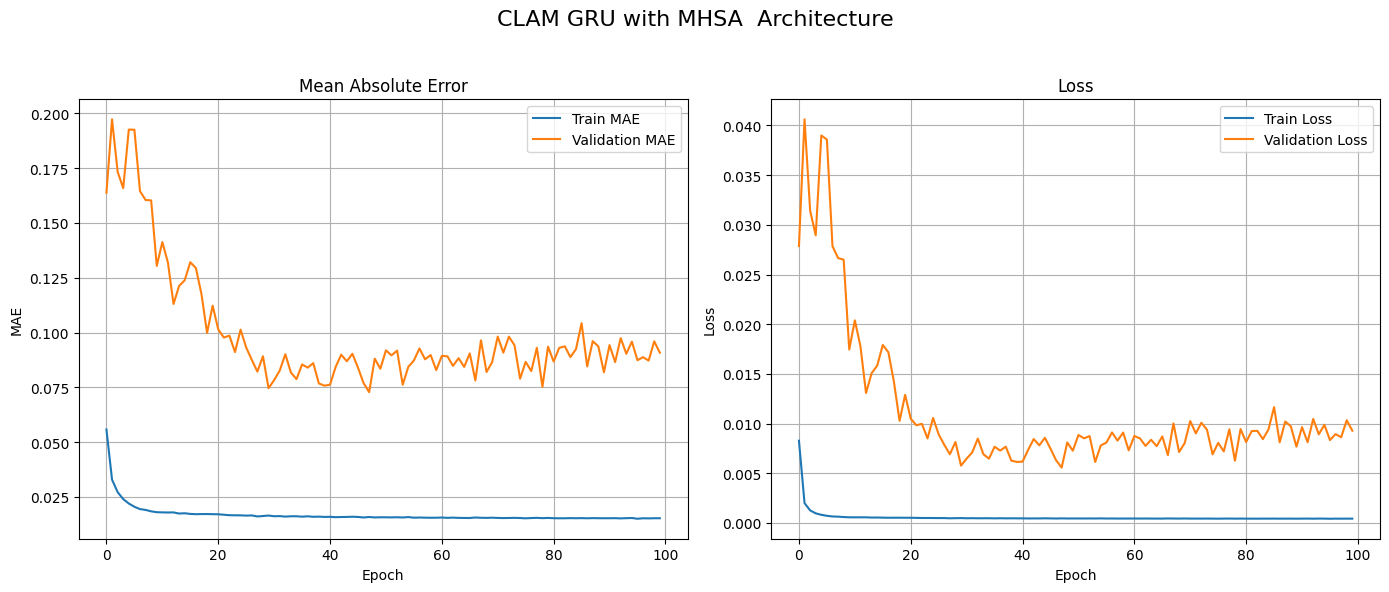

In [27]:
import matplotlib.pyplot as plt

# Create a side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("CLAM GRU with MHSA  Architecture", fontsize=16)

# --- Plot 1: MAE ---
axes[0].plot(history.history['mean_absolute_error'], label='Train MAE')
axes[0].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axes[0].set_title('Mean Absolute Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend(loc='upper right')
axes[0].grid(True)

# --- Plot 2: Loss ---
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.savefig("clam_gru_side_by_side_plots.png", dpi=600)
plt.show()


In [ ]:
def build_tcn_mhsa_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = cnn_block(inputs)

    # ---- TCN Block (stacked dilated convolutions + residuals) ----
    x = tcn_block(
        x,
        filters=64,
        kernel_size=3,
        dilations=[1, 2, 4, 8, 16]   # very important for TCN!
    )

    # ---- second TCN stage (deeper model) ----
    x = tcn_block(
        x,
        filters=32,
        kernel_size=3,
        dilations=[1, 2, 4, 8]
    )

    attention = MultiHeadSelfAttention(
        num_heads=4,
        head_dim=32,
        dropout_rate=0.1,
        use_causal_mask=True  # Ensures no future peeking
    )(x)

    outputs = Dense(FORECAST_LENGTH)(attention)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse",
                  metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

    return model

model = build_tcn_mhsa_model((SEQ_LENGTH, 5))
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=200,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=0.001
)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Save the trained model
model.save('tcn_mhsa_model.h5')

# Evaluate the model
mae = model.evaluate(X_val, y_val)[1]
rmse = model.evaluate(X_val, y_val)[2]
print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 60, 128)   │      2,048 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 60, 128)   │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 60, 128)   │     49,280 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 60, 128)   │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 60, 128)   │     49,280 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 60, 128)   │          0 │ conv1d_5[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 60, 64)    │     24,640 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 60, 64)    │          0 │ conv1d_6[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 60, 64)    │     12,352 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 60, 64)    │      8,256 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 64)    │          0 │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 60, 64)    │          0 │ add[0][0]         │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 60, 64)    │     12,352 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 60, 64)    │          0 │ conv1d_9[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 60, 64)    │     12,352 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 64)    │          0 │ conv1d_10[0][0],  │
│                     │                   │            │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 60, 64)    │          0 │ add_1[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 60, 64)    │     12,352 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 60, 64)    │          0 │ conv1d_11[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 291,897 (1.11 MB)

 Trainable params: 291,897 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 148s 139ms/step - loss: 0.0219 - mean_absolute_error: 0.0819 - root_mean_squared_error: 0.1480 - val_loss: 0.4329 - val_mean_absolute_error: 0.6510 - val_root_mean_squared_error: 0.6580 - learning_rate: 0.0010
Epoch 2/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 138s 138ms/step - loss: 0.0042 - mean_absolute_error: 0.0469 - root_mean_squared_error: 0.0647 - val_loss: 0.4307 - val_mean_absolute_error: 0.6493 - val_root_mean_squared_error: 0.6563 - learning_rate: 0.0010
Epoch 3/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - loss: 0.0028 - mean_absolute_error: 0.0388 - root_mean_squared_error: 0.0525 - val_loss: 0.4346 - val_mean_absolute_error: 0.6535 - val_root_mean_squared_error: 0.6592 - learning_rate: 0.0010
Epoch 4/100
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - loss: 0.0020 - mean_absolute_error: 0.0337 - root_mean_squared_error: 0.0444 - val_loss: 0.3205 - val_mean_absolute_error: 0.5624 - val_root_mean_squared_error: 0.5661 - learning_r

223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0043 - mean_absolute_error: 0.0635 - root_mean_squared_error: 0.0656
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0043 - mean_absolute_error: 0.0635 - root_mean_squared_error: 0.0656
Validation MAE: 0.0635390430688858
Validation RMSE: 0.06555072218179703


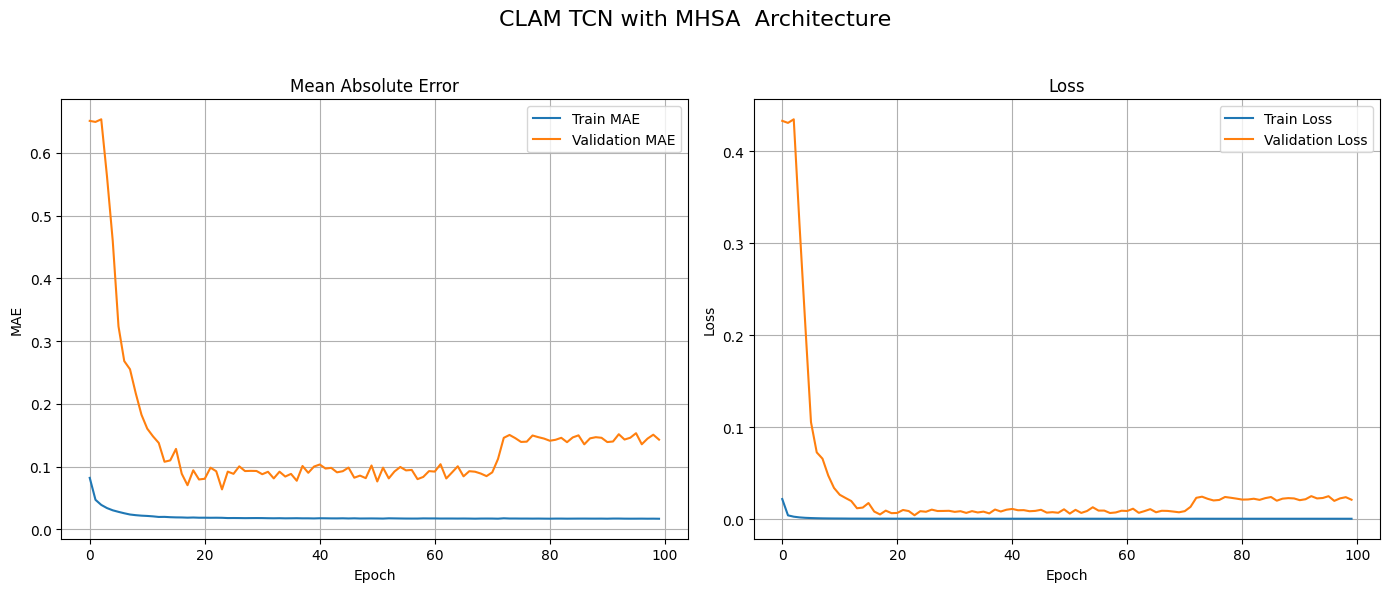

In [15]:
import matplotlib.pyplot as plt

# Create a side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("CLAM TCN with MHSA  Architecture", fontsize=16)

# --- Plot 1: MAE ---
axes[0].plot(history.history['mean_absolute_error'], label='Train MAE')
axes[0].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axes[0].set_title('Mean Absolute Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend(loc='upper right')
axes[0].grid(True)

# --- Plot 2: Loss ---
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.savefig("clam_tcn_mha_side_by_side_plots.png", dpi=600)
plt.show()
